<a href="https://colab.research.google.com/github/YinYinTan/CIND820FinalProject/blob/main/5a_SVM_Classification_Models_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine (SVM) Classification Models using Working Dataset with Principal Components

In [4]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import time

In [5]:
#Read file
df = pd.read_csv('3b. Working Dataset - PCA.csv', index_col=None)

# 1. All Principal Components in Working Dataset - Evaluation using Train-Test Split

In [6]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [7]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#SVM classification model

t1 = time.perf_counter() #time counter start

model = svm.SVC(random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

t2 = time.perf_counter() #time counter ends

#Save results into dictionary
svm_all_base_pca = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time (sec)':int(t2-t1)}

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))
print('Execution time in seconds:', int(t2-t1))

Accuracy: 0.6498267898383372
Precision: 0.7829232995658466
Recall: 0.6802179379715004
F1-score: 0.7279659116393811
Area Under Curve (AUC): 0.6313891174087557
Brier Score: 0.3501732101616628
Execution time in seconds: 41


# 2. All Principal Components in Working Dataset - Hyperparameter Tuning
In this section, a grid of hyperparameter ranges will be defined, and where k-fold cross validation will be performed with all combinations.

In [8]:
from pprint import pprint

#Look at parameters currently used by the model
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 888,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


The following set of hyperparameters will be adjusted to narrow down the best combination of parameters:
*   C = Regularization parameter of the error term. The C value adds a penalty each time an item is misclassified. Thus, a low C value has more misclassified items, while a large C value has a plane with a very little margin that leads to overfitting.
*   gamma = Coefficient of the RBF kernel. A non-linear kernel like the RBF kernel uses a gamma value. It determines the influence of training points on the decision boundary. If the gamma value is low, all training points have an influence on the decision line, and the radius of similarity is high. If the gamma value is high, the radius of similarity is low and influence is limited only to the nearby points. A larger gamma value, therefore, results in overfitting.

In [9]:
from sklearn.model_selection import GridSearchCV

#Create the parameter grid. This will try out 5 * 5 = 25 combinations of settings.
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
}

#Create the base model to tune
model = svm.SVC(random_state=888)

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'recall', n_jobs = -1, verbose = 2)

#Fit the grid search model
grid_search.fit(X_train, y_train)

#View the best parameters from fitting the grid search (based on model with the best recall)
grid_search.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'C': 1, 'gamma': 1}

In [10]:
#Evaluate performance of best model from grid search
best = grid_search.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.6423210161662818
Precision: 0.7230649552703229
Recall: 0.7791282481139983
F1-score: 0.7500504337300787
Area Under Curve (AUC): 0.5593229366729546
Brier Score: 0.35767898383371827


Compared to the default SVC parameters used in the prior "All Principal Components in Working Dataset - Evaluation using Train-Test Split" section, the best model from the grid search resulted in a 9.9% increase in Recall (the metric chosen for scoring).
*   The F1-score also improved by 2.2%.
*   However, performance reduced for all other metrics. AUC was 7.2% lower, followed by Precision (6.0% lower), Accuracy (0.8% lower) and Brier Score (0.8% higher).

The best model found in the grid search has the same values for C as the default model (i.e. C = 1). Thus, the only parameter "tuned" was gamma.

In [11]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[ 366  712]
 [ 527 1859]]


# 3. All Principal Components in Working Dataset, Using Parameters from Grid Search - Evaluation using Repeated 10-fold Cross Validation

In [12]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold

#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#SVM classification model
model = svm.SVC(C=1, gamma=1, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
svm_all_tuned_pca = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of SVM classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6433589318362035
Precision: 0.7279956220424239
Recall: 0.769916843406073
F1-score: 0.748332709390702
Area Under Curve (AUC): 0.5665910747642611
Brier Score: 0.3566410681637967
Execution time in seconds: 81.49708263036663


# 4. Top Principal Components

## 4.1 Top Principal Components
It was decided to build SVM models using the top 1 to all principal components to compare performance.

In [26]:
#Build classification model using 1 to all of the principal components and compare performance on Recall

recall_test = []
components = len(df.columns)

for n in range(1, components):

  #Split dataframe, using 80% for training and 20% for testing
  #Only select top n variables for X
  X = df.iloc[:,:n]
  y = df['Worse_MH']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #SVM classification model, using the parameters identified during hyperparameter tuning
  model = svm.SVC(C=1, gamma=1, random_state=888)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  #Save results into list
  recall_test.append(metrics.recall_score(y_test, y_pred))

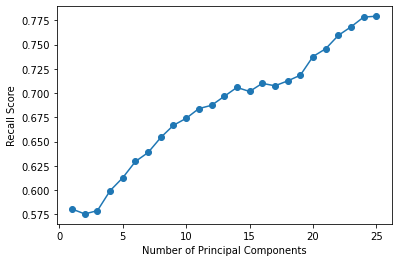

In [27]:
#Plot recall scores against number of features used
plt.plot(range(1,components), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Principal Components')
plt.show()

Based on the plot above, it appears that model performance increases as more principal components are used, until 24 components are reached. Recall score for 24 versus 25 principal components are roughly equal.



## 4.2 Top 24 Features, Filter Method - Evaluation using Repeated 10-fold Cross Validation
Based on the results above, it was decided to build a SVM model using the top 24 features.

In [28]:
#Only select top 24 components for X
X = df.iloc[:,:24]
y = df['Worse_MH']

In [29]:
#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#SVM classification model, using the parameters identified during hyperparameter tuning
model = svm.SVC(C=1, gamma=1, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Mifilnority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
svm_24_tuned_pca = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of SVM classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.6438594279294964
Precision: 0.7315411679231411
Recall: 0.762986970977233
F1-score: 0.7468870747297449
Area Under Curve (AUC): 0.5715986184508923
Brier Score: 0.3561405720705035
Execution time in seconds: 73.42844921190002


# 5. Comparison of Models

In [30]:
#Combine performance metrics for all models into one dataframe
comparison = pd.DataFrame([svm_all_base_pca, svm_all_tuned_pca, svm_24_tuned_pca], index=['SVM All Components - Base (PCA)','SVM All Components - Tuned (PCA)','SVM 24 Components - Tuned (PAC)'])
comparison

,Accuracy,Precision,Recall,F1-Score,AUC,Brier Score,Execution Time (sec)
SVM All Components - Base (PCA),0.649827,0.782923,0.680218,0.727966,0.631389,0.350173,41.000000
SVM All Components - Tuned (PCA),0.643359,0.727996,0.769917,0.748333,0.566591,0.356641,81.497083
SVM 24 Components - Tuned (PAC),0.643859,0.731541,0.762987,0.746887,0.571599,0.356141,73.428449


'SVM All Components - Tuned (PCA)', the SVM model using all principal components and the parameters identified during hyperparameter tuning, had the best Recall with a reasonable execution time of 82 seconds. THe Recall was 9% higher than the "SVM All Components - Base (PCA)" model.
*   The model also had the best F1-score.
*   The model performed slightly worse for Accuracy, Precision, AUC, and Brier Score (0.6%, 5.5%, 6.5% amd 0.6% worse, respectively).



# 6. Stability of Best Model by Varying k-folds for Cross Validation

The stability of the best model identified above was tested by performing repeated k-folds cross-validation, with values of k from 5 to 12.
*   Originally, values of k from 3 to 15 were used, but execution runtime exceeded 10 hours before the decision was made to interrupt execution. Values of k were then changed to reduce runtime.



In [31]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

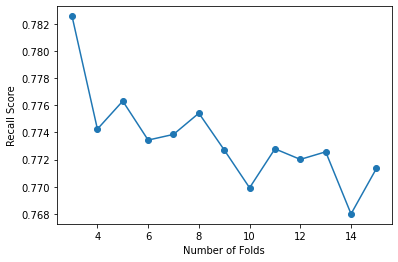

Range of Recall Scores (percent): 1.458573073056224


In [32]:
recall_test = []

for k in range(5, 13):
  #Set cross-validation to k-folds, repeated 3 times
  repeats = 3
  rkf = RepeatedStratifiedKFold(n_splits=k, n_repeats=3, random_state=888)

  #Best SVM classification model identified in section 5, 'SVM All Features - Tuned'
  model = svm.SVC(C=1, gamma=1, random_state=888)

  #Performance metrics
  recall = 0

  for train_index, test_index in rkf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
    smote = SMOTE(random_state = 888)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    recall = recall + metrics.recall_score(y_test, y_pred)

  #Calculate average recall, append to list
  recall_test.append(recall/(k*repeats))

#Plot recall scores against number of folds used
plt.plot(range(5, 13), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Folds')
plt.show()

print("Range of Recall Scores (percent):", (max(recall_test)-min(recall_test))*100)

The model appears to be quite stable, with Recall ranging by less than 1.5%.